<a href="https://colab.research.google.com/github/marcelarosalesj/e2e-vision-apps/blob/main/Week_3_Project_Face_ID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### This project is from [Abubakar Abid's](https://twitter.com/abidlabs) course: *Building Computer Vision Applications* on CoRise. Learn more about the course [here](https://corise.com/course/vision-applications).

# Week 3 Project: Building a Facial Identity Recognition System

Welcome to the third week's project for *Building Computer Vision Applications*!

In this week, we are going to get familiar with the key steps of machine learning, with a particular focus on image embedding. Specifically, we will cover:

* finding pretrained image embedding models and using them on our own data 👾
* building an image dataset and uploading it to the Hugging Face Hub 📖
* measuring the performance of an image embedding model on test data and the real world 📈
* building a facial identity recognition app you can run on your phone or laptop 📷


# Introduction

[Face ID](https://en.wikipedia.org/wiki/Face_ID) was introduced by Apple in 2017 as an alternative to fingerprint-based authentication for iPhones. The way that Face ID works is that it uses infrared projectors that shine around 30,000 infrared dots onto a user's face. Then an infrared camera reads the reflections to come up with an infrared "image" of a person's face. Using neural networks, Face ID predicts if the recorded infrared image is similar enough to a stored profile, in which case the phone unlocks.

In this project, we will recreate the last part of this process -- building an application that can recognize if two faces belong to the same person, based on optical pictures (i.e. regular images, not infrared images) of their face. This is quite a difficult problem because it requires us to simultaneously perform two tasks: (1) tell two people (who may look quite similar) apart (2) recognize that two photos of the same person (potentially taken in very different lighting, clothing, or other conditions) are of the same person. In order to do this project, we will use models for *image embedding*, which can convert any image to a numerical vector called an embedding. These embeddings can be used to compare images more easily, as computing distances between different embeddings can be a meaningful signal of how similar the respective images are.

By the end of this project, you'll have built an app that takes in two pictures from your webcam and will predict whether they are the same person or not. This can form the basis of facial identity recognition software. It will look something like this:

![](https://i.ibb.co/T0cDVLs/image.png)

# Step 0: Hardware Setup & Software Libraries

We will be utilizing GPUs to train our machine learning model, so we will need to make sure that our colab notebook is set up correctly. Go to the menu bar and click on Runtime > Change runtime type > Hardware accelerator and **make sure it is set to GPU**. Your colab notebook may restart once you make the change.

We're going to be using some fantastic open-source Python libraries to upload our dataset (`datasets`), load our model (`sentence-transformers`), evaluate our model (`scikit-learn`), and build a demo of our model (`gradio`). So let's go ahead and install all of these libraries. 

In [1]:
!pip install datasets huggingface_hub sentence-transformers gradio 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 432 kB 37.7 MB/s 
     |████████████████████████████████| 163 kB 68.1 MB/s 
     |████████████████████████████████| 85 kB 4.8 MB/s 
     |████████████████████████████████| 5.3 MB 51.7 MB/s 
     |████████████████████████████████| 115 kB 67.8 MB/s 
     |████████████████████████████████| 212 kB 69.3 MB/s 
     |████████████████████████████████| 127 kB 60.0 MB/s 
     |████████████████████████████████| 4.9 MB 40.4 MB/s 
     |████████████████████████████████| 1.3 MB 48.7 MB/s 
     |████████████████████████████████| 6.6 MB 58.4 MB/s 
     |████████████████████████████████| 84 kB 4.5 MB/s 
     |████████████████████████████████| 270 kB 71.3 MB/s 
     |████████████████████████████████| 57 kB 6.2 MB/s 
     |████████████████████████████████| 112 kB 72.5 MB/s 
     |████████████████████████████████| 2.3 MB 56.0 MB/s 
     |███████████████████████████████

In Week 2, you uploaded a model to your Hugging Face account programmatically. This week, you'll be uploading a dataset! The first step is to log in using your Hugging Face token:

In [2]:
from huggingface_hub import notebook_login

In [3]:
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


# Step 1: Loading Pretrained Image Embedding Models

In this project, we will be loading several pretrained image embedding models and comparing their performance. In particular, we will compare:

* https://huggingface.co/sentence-transformers/clip-ViT-B-16
* https://huggingface.co/sentence-transformers/clip-ViT-B-32
* https://huggingface.co/sentence-transformers/clip-ViT-L-14

* **1a. Compare the models**

When considering which machine learning model to use for a particular task, there are several things to consider:
* The metrics that are relevant to you
* The size of the model
* The inference time of the model

Which of these models has the best reported performance on the model card? Which has the worst reported performance?
* clip-ViT-L-14 has the best performance (75.4% accuracy)
* clip-ViT-B-32	has the worst performance (63.3% accuracy)


What task was the performance reported on? What does this task mean?
* The task was zero-shot ImageNet classification. This means that the three models were trained for classification.


Which of these models has the the largest size on disk? Which is the smallest? *Hint*: look for the PyTorch binary file.
* clip-ViT-L-14 has the largest size on disk because its binary size is 1.71 GB
* clip-ViT-B-16 has the smallest size on disk because its binary size is 599 MB


What model do you expect to run the fastest? The slowest?
* Probably clip-ViT-B-16 is gong to be faster because it is less complex than clip-ViT-L-14. I think it is less complex because it is smaller in disk size.
* Similarly, clip-ViT-L-14 is going to be the slowest.



* **1b. Load one of the models**

Pick one of the three models above and load it using the [Sentence Transformers](https://www.sbert.net/) library.

In [108]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("clip-ViT-L-14")

* **1c. Use the model to embed a few photos with faces**

The following code downloads and displays 3 images from the web. We will use the `SentenceTransformer` you downloaded above to embed these images.

Robert Downey Jr


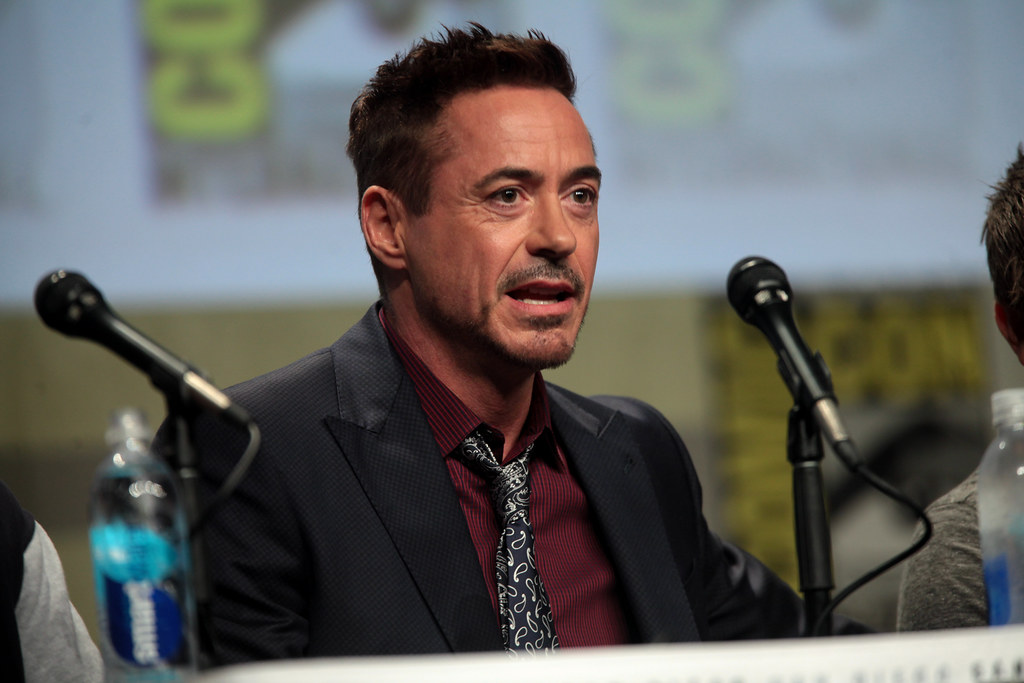

Robert Downey Jr


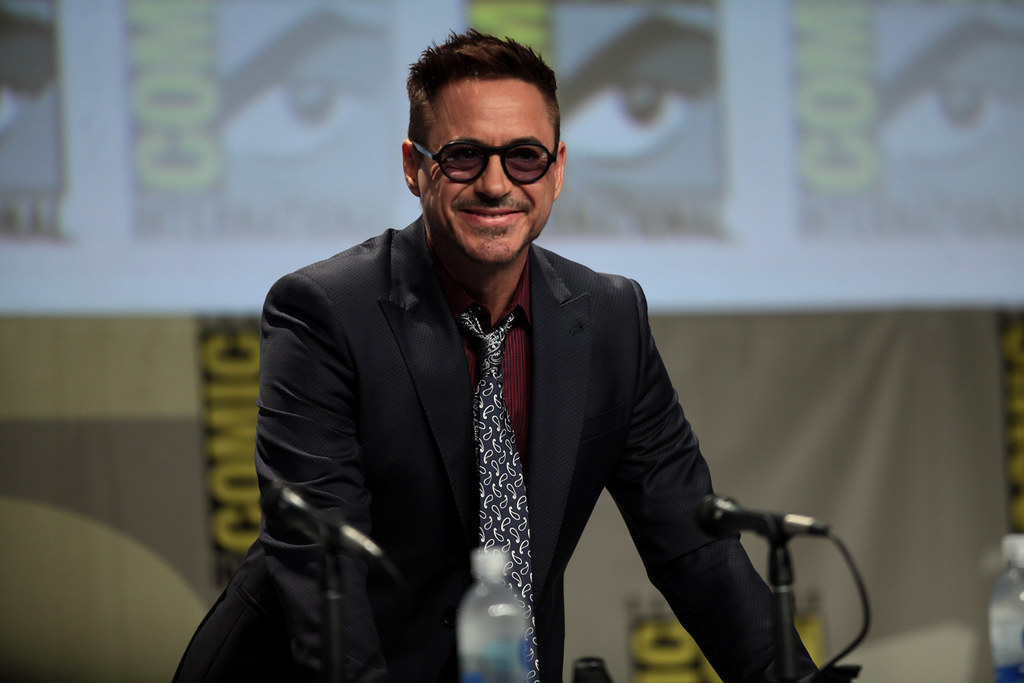

Gwyneth Paltrow


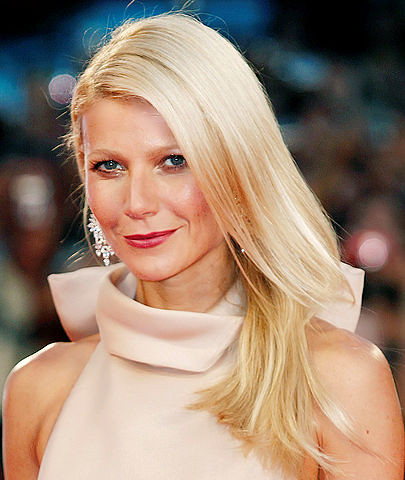

In [129]:
from PIL import Image
from io import BytesIO
import requests

urls = {
    "https://live.staticflickr.com/5551/14616229927_7ed70f7836_b.jpg": "Robert Downey Jr",
    "https://live.staticflickr.com/3849/14800476884_6dbda11c8c_b.jpg": "Robert Downey Jr",
    "https://live.staticflickr.com/8187/8138909428_2d9e94332a.jpg": "Gwyneth Paltrow"
}

image_list = []

for index, (url, label) in enumerate(urls.items()):
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  image_list.append(img)
  print(label)
  display(img)

Use the `SentenceTransformer` model to embed these images.

In [130]:
img_emb = model.encode(image_list)

* **1d. Explore the embeddings**

* What are the dimensions of the images we downloaded? 

In [131]:
for img in image_list:
  print(img.size)

(1024, 683)
(1024, 683)
(405, 480)


* What is the dimensionality of the embedding for each image?


In [132]:
for img in img_emb:
  print(img.shape)

(768,)
(768,)
(768,)




* Do the dimensions of the images affect the dimensionality of the embedding? 

No, the three images were converted to a 768 dimension numpy array.

* Finally, let's compare how similar the image embeddings are to each other. We will use [*cosine similarity*](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html), the metric we discussed in lecture to compare image similarity.

In [142]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Reshape img_emb to suit sklearn cosine_similarity
img_emb_reshaped = [np.reshape(img, (1, -1)) for img in img_emb]

cos_scores = cosine_similarity(img_emb_reshaped[0],
                                 img_emb_reshaped[1])
print(f"Cosine similarity imgage 1 and 2: {cos_scores}")

cos_scores = cosine_similarity(img_emb_reshaped[0],
                                 img_emb_reshaped[2])
print(f"Cosine similarity imgage 1 and 3: {cos_scores}")

Cosine similarity imgage 1 and 2: [[0.95294297]]
Cosine similarity imgage 1 and 3: [[0.6407103]]


According to the embedding model:
* What is the cosine similarity between image 1 and image 2?
 * 0.95294297
* What is the cosine similarity between image 1 and image 3?
 * 0.6407103

Is this what you expected?
* Yes, because image 1 and 2 are pictures of the same person, but image 3 contains a different person.

# Step 2: Finding and Uploading a Dataset

In order to test our embedding models more systematically, we'll need an entire dataset, not just a few samples. For this assignment, you will build your OWN dataset by downloading images of celebrities' faces. The purpose of this step is to think about how to build a representative dataset

Here are some things to consider as you build your own dataset:

* Dataset diversity: choose **at least 6 different celebrities** (Can you choose celebrities of different ages, ethnicities, genders? What other considerations are important here?) 
* Dataset size: Since we are not training an image embedding model from scratch, but simply evaluating different models, we will not require a particularly large dataset. Please have **at least 3 images per celebrity** (so your total dataset size should be at least 18 images.)
* Dataset consistency: all of the images in the dataset should consist primarily of **celebrity faces** only
* Dataset balance: you may want to have a dataset that is relatively balanced among the different celebrities
* Dataset license: you should make sure to use images under a permissive license, such as Creative Commons.

We suggest using either [Openverse](https://wordpress.org/openverse/) or [Flickr](https://flickr.com/) to easily find images that are under a Creative Commons license. 

First, create a dictionary, whose keys are image URLs and whose labels are the name of the celebrity (similar to the `urls` dictionary in step 1b):

In [143]:
urls = {
    "https://live.staticflickr.com/5551/14616229927_7ed70f7836_b.jpg": "Robert Downey Jr",
    "https://live.staticflickr.com/2932/14802403202_185a738949_b.jpg": "Robert Downey Jr",
    "https://live.staticflickr.com/8158/7571852962_6780b90342_b.jpg": "Robert Downey Jr",
    "https://live.staticflickr.com/2836/9363891296_ed5d4e2a1c_b.jpg": "Chris Evans",
    "https://live.staticflickr.com/2946/15472529775_86acbc2c21_b.jpg": "Chris Evans",
    "https://live.staticflickr.com/6133/5963443244_475dae64fe_b.jpg": "Chris Evans",
    "https://live.staticflickr.com/2837/9353981123_df789a73fc_b.jpg": "Elizabeth Olsen",
    "https://upload.wikimedia.org/wikipedia/commons/1/10/Elizabeth_Olsen_SDCC_2014_2_%28cropped%29.jpg": "Elizabeth Olsen",
    "https://live.staticflickr.com/5551/14802536275_cd1a6c1b6f_b.jpg": "Elizabeth Olsen",
    "https://live.staticflickr.com/5519/9361353623_3d1fc158d4_b.jpg": "Scarlett Johansson",
    "https://live.staticflickr.com/4073/35593707562_3379996e4a_b.jpg": "Scarlett Johansson",
    "https://live.staticflickr.com/7459/9361107297_35ede51a31_b.jpg": "Scarlett Johansson",
    "https://live.staticflickr.com/4323/35852212110_81c9a6eec0_b.jpg": "Chadwick Boseman",
    "https://live.staticflickr.com/65535/50281415767_c607005287.jpg": "Chadwick Boseman",
    "https://live.staticflickr.com/4303/36245604005_8a4ae0edd2_b.jpg": "Chadwick Boseman",
    "https://live.staticflickr.com/7663/28652888235_a59cb973a1_b.jpg": "Tom Holland",
    "https://live.staticflickr.com/8086/28652891355_3e16deaf2e_b.jpg": "Tom Holland",
    "https://live.staticflickr.com/8046/8097182033_c5c68944ff.jpg": "Tom Holland",
}

Then, run the following code to download the images and save them into organized folders:

In [144]:
from PIL import Image
from io import BytesIO
import requests
import os

image_list = []
root_path = "celebrity_images/train"

def strip_invalid_filename_characters(filename) -> str:
    filename = filename.replace(" ", "_")
    return ("".join([char for char in filename if char.isalnum() or char in "._- "]))

# Save the images into an organized directory structure
for index, (url, label) in enumerate(urls.items()):
  class_path = os.path.join(root_path, strip_invalid_filename_characters(label))
  os.makedirs(class_path, exist_ok=True)

  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  filename = url.split("/")[-1]
  img.save(os.path.join(class_path, filename))

  image_list.append(img)

Now, load this dataset using the `datasets` library using the `ImageFolder` dataset builder. You might find this reference useful: https://huggingface.co/docs/datasets/image_load#imagefolder

In [145]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="celebrity_images")

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-f873d9515703be2f/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [146]:
dataset['train']

Dataset({
    features: ['image', 'label'],
    num_rows: 18
})

Answer a few questions about the dataset you've built:

* Dataset size: How many images are in your dataset? How many different "labels" are there?

 * There are 18 images in my dataset, with 6 different labels.

* Dataset diversity: How what diversity / representativeness considerations did you take when building your dataset?

 * For my dataset I chose avengers actors, I considered variety in age, gender and skin color.


* **Push the Dataset to the Hugging Face Hub**

Now that you have a dataset, upload it to the Hugging Face Hub so that you can share it with others! Here is some information about uploading datasets to the Hub: https://huggingface.co/docs/datasets/upload_dataset#upload-with-python


In [74]:
dataset.push_to_hub("celeb-identities")

  0%|          | 0/1 [00:00<?, ?ba/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Once you've uploaded your dataset, you should be able to preview the dataset, and see the number of samples and the labels of the each sample! 

What is the URL to your dataset: https://huggingface.co/datasets/marcelarosalesj/celeb-identities

Please make sure that the dataset is **public**

# Step 3: Evaluating the Embedding Models on your Dataset

Now, let's evaluate each of the models on the dataset you've built. For this example, we will evaluate how good the embeddings from the same celebrity. "cluster" together. 

So we now have to decide on a *metric* we will use to measure the performance for our machine learning models. There are many different metrics that allow you to assess the quality of clustering results. We will use the silhouette score (SS). This measure has a range of [-1, 1] and is calculated using the mean intra-cluster distance ($a$) and the mean nearest-cluster distance ($b$) for each sample. The SS for a _single sample_ is $(b - a) / \text{max}(a, b)$, where $b$ is the distance between a sample and the nearest cluster that the sample is not a part of.

![](https://uploads-ssl.webflow.com/5f5148a709e16c7d368ea080/5f7dea907b8e8c7769e769c8_5f7c9650bc3b1ed0ad2247eb_silhouette_formula.jpg)

We then take the average of value of the SS across all samples to get a single SS for our entire dataset.

In this case, we will be using the `sklearn.metrics.silhouette_score` function which takes in two required parameters: (1) a matrix consisting of the embeddings of a list of samples and (2) a list of labels. 

Using each of these three models:
* https://huggingface.co/sentence-transformers/clip-ViT-B-16
* https://huggingface.co/sentence-transformers/clip-ViT-B-32
* https://huggingface.co/sentence-transformers/clip-ViT-L-14

create embeddings for all of the training images of the celebrities. And then compute the SS metric for all of the embeddings. Also record the running time for computing the embeddings for each model.


In [93]:
 # Load all of the models 

model_names = ["clip-ViT-B-16", "clip-ViT-B-32", "clip-ViT-L-14"]
models = [SentenceTransformer(model_name) for model_name in model_names]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


In [95]:
import time
from sklearn.metrics import silhouette_score
import time

for index, model in enumerate(models):
  img_emb = model.encode(dataset['train']['image'])
  img_labels = dataset['train']['label']
  start = time.time()
  s_score = silhouette_score(img_emb, img_labels)
  end = time.time()
  print(f"{model_names[index]} silhouette score={s_score} time={end-start} seconds")


clip-ViT-B-16 silhouette score=0.20836907625198364 time=0.0017304420471191406 seconds
clip-ViT-B-32 silhouette score=0.18963521718978882 time=0.0010657310485839844 seconds
clip-ViT-L-14 silhouette score=0.23566964268684387 time=0.0012845993041992188 seconds


What SS and running time do you get with each model?
* clip-ViT-B-16 silhouette score=0.20836907625198364 time=0.0017304420471191406 seconds
* clip-ViT-B-32 silhouette score=0.18963521718978882 time=0.0010657310485839844 seconds
* clip-ViT-L-14 silhouette score=0.23566964268684387 time=0.0012845993041992188 seconds

If you had to pick one model to use for facial identity recognition, which one would it be? Why? 

* clip-ViT-L-14 because it had a lager silhouette score

# Step 4: Choosing a Distance Threshold

In order to use this model for facial identity recognition, we need to choose a _similarity threshold_. If two faces are similar enough to each other (above this threshold), we will quantify them as being from the same person. If they are below this threshold, we will quantify them as different. Using the model you identified in the previous part, let's first compute the average distance between each pair of embeddings, as well as the average distance between each pair of embeddings of images that belong to the same celebrity.

Again, we'll find *cosine_similarity* quite useful

In [268]:
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations
import numpy as np

model = SentenceTransformer("clip-ViT-L-14")
embeddings = model.encode(dataset['train']['image'])

embeddings_reshaped = [np.reshape(img, (1, -1)) for img in embeddings]

similarities = {}

all_combinations = list(combinations(range(len(embeddings_reshaped)), 2))

for comb in all_combinations:
  similarities[f"{comb[0]}-{comb[1]}"] = cosine_similarity(embeddings_reshaped[comb[0]], embeddings_reshaped[comb[1]])

* What is the average cosine similarity between **all images**?

In [269]:
import numpy as np
np.average(list(similarities.values()))

0.7073787

* What is the average cosine similarity between all images of the **same celebrity**?

In [270]:
# First, Let's build these dictionaries with the relationships between class label, photo id and the class name.
label_names = {0: 'Chadwick_Boseman', 1: "Chris_Evans", 2: "Elizabeth_Olsen", 3: "Robert_Downey_Jr", 4: "Scarlett_Johansson", 5: "Tom_Holland"}
photo_id_to_label = {}

for idx, label in enumerate(dataset['train']['label']):
  photo_id_to_label[idx] = label
print("photo_id_to_label: ", photo_id_to_label)


photo_id_to_label:  {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 2, 7: 2, 8: 2, 9: 3, 10: 3, 11: 3, 12: 4, 13: 4, 14: 4, 15: 5, 16: 5, 17: 5}


In [276]:
# Now, let's group similarities by label
same_label_similarities = {0: [], 1: [], 2: [], 3: [], 4: [], 5: []}

for k, v in similarities.items():
  photo_id1, photo_id2 = k.split('-')
  label_photo_id1 = photo_id_to_label[int(photo_id1)]
  label_photo_id2 = photo_id_to_label[int(photo_id2)]
  if label_photo_id1 == label_photo_id2:
    same_label_similarities[label_photo_id1].append(v)

In [277]:
same_label_similarities

{0: [array([[0.9526034]], dtype=float32),
  array([[0.7796117]], dtype=float32),
  array([[0.77333975]], dtype=float32)],
 1: [array([[0.86563337]], dtype=float32),
  array([[0.8315088]], dtype=float32),
  array([[0.89068276]], dtype=float32)],
 2: [array([[0.8530797]], dtype=float32),
  array([[0.8353569]], dtype=float32),
  array([[0.81160736]], dtype=float32)],
 3: [array([[0.984457]], dtype=float32),
  array([[0.8624357]], dtype=float32),
  array([[0.8701775]], dtype=float32)],
 4: [array([[0.7087975]], dtype=float32),
  array([[0.653952]], dtype=float32),
  array([[0.9140854]], dtype=float32)],
 5: [array([[0.9739846]], dtype=float32),
  array([[0.8072951]], dtype=float32),
  array([[0.8318977]], dtype=float32)]}

In [282]:
import numpy as np

for k, v in same_label_similarities.items():
  print(f"For label {k} - average similarity against same label is {np.average(v)}")

For label 0 - average similarity against same label is 0.8351849913597107
For label 1 - average similarity against same label is 0.8626082539558411
For label 2 - average similarity against same label is 0.8333479762077332
For label 3 - average similarity against same label is 0.9056900143623352
For label 4 - average similarity against same label is 0.7589449882507324
For label 5 - average similarity against same label is 0.8710591197013855


Based on the above calculations, what similarity threshold do you pick, and why?

* I think I'll chose 72% because it is larger than the images of all celebrities and lower than the lowest similarity of the same celebrity.

# Step 5: Building a Demo

A high-level metric like accuracy doesn't give us a great idea on how the model will work when presented with new data from the real world. To understand this, we will build a web-based demo that can be used on our phones or computers through a web browser to test our model.

The `gradio` library lets you build web demos of machine learning models with just a few lines code. Learn more about Gradio here: https://gradio.app/getting_started/

Gradio lets you build machine learning demos simply by specifying (1) a prediction function, (2) the input type and (3) the output type of your model. Write a prediction function that takes in two images and returns "SAME PERSON, UNLOCK PHONE" if they are within the distance threshold and "DIFFERENT PEOPLE, DON'T UNLOCK" if they are above the distance threshold 

In [287]:
import matplotlib.pyplot as plt

def predict(im1, im2):
  embeddings = model.encode([im1, im2])
  embeddings_reshaped = [np.reshape(img, (1, -1)) for img in embeddings]
  sim = cosine_similarity(embeddings_reshaped[0], embeddings_reshaped[1])

  if sim > 0.72:
    return sim, "SAME PERSON, UNLOCK PHONE"
  else:
    return sim, "DIFFERENT PEOPLE, DON'T UNLOCK"

* **Build a Gradio web demo of your image classifier and `launch()` it**

Create a `gradio.Interface` and launch it! In this case, we've provided the Gradio code that you need to launch the demo.

In [286]:
import gradio as gr

interface = gr.Interface(fn=predict, 
                         inputs= [gr.Image(type="pil", source="webcam"), 
                                  gr.Image(type="pil", source="webcam")], 
                         outputs= [gr.Number(label="Similarity"),
                                   gr.Textbox(label="Message")]
                         )

interface.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Your interface requires microphone or webcam permissions - this may cause issues in Colab. Use the External URL in case of issues.
Running on public URL: https://29679.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/gradio/routes.py", line 276, in run_predict
    fn_index, raw_input, username, session_state, iterators
  File "/usr/local/lib/python3.7/dist-packages/gradio/blocks.py", line 785, in process_api
    result = await self.call_function(fn_index, inputs, iterator)
  File "/usr/local/lib/python3.7/dist-packages/gradio/blocks.py", line 695, in call_function
    block_fn.fn, *processed_input, limiter=self.limiter
  File "/usr/local/lib/python3.7/dist-packages/anyio/to_thread.py", line 32, in run_sync
    func, *args, cancellable=cancellable, limiter=limiter
  File "/usr/local/lib/python3.7/dist-packages/anyio/_backends/_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.7/dist-packages/anyio/_backends/_asyncio.py", line 867, in run
    result = context.run(func, *args)
  File "<ipython-input-285-e3d60d44e832>", line 5, in predict
    embeddings = model.enco

Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7fa0509d2a50>,
 'http://127.0.0.1:7860/',
 'https://29679.gradio.app')

## Step 5b: Upload your Demo to Spaces (Optional)

Although we don't require it, we highly recommend that you upload your Gradio app to Hugging Face Spaces as it will allow you to easily share it with others or add it to your machine learning portfolio!

1. Create a new **public** Space with the code for your Gradio app. You might find this tutorial helpful: https://huggingface.co/blog/gradio-spaces (Note that in addition to uploading the code for your Gradio demo, you'll also need to upload the saved model files, as well as a `requirements.txt` file).
1. Once your app launches, please put the link to your Space here:

https://huggingface.co/spaces/marcelarosalesj/face-id


# Step 6: Trying your Model with "Real World" Data!

* **Use the share link (or Space link if you completed 5b) created above to open up your app on your phone**

Now test your model on some real images -- of yourself or your friends. What do you notice about the performance of your model on your own images versus those on the training set?  

I tested it myself and the performance seems to be very good, I tested doing different gestures and it recognize my different photos to be the same person, which is correct.

# Bonus: Extensions

Now that you've worked through the project and have a functioning app, what else can we do to improve our results?

* **Extract faces from images**: One way to dramatically improve the performance of our app would be to do some preprocessing to [extract faces](https://www.digitalocean.com/community/tutorials/how-to-detect-and-extract-faces-from-an-image-with-opencv-and-python) from an image before it is passed into the image embedding. Can you implement this and see how your embedding results change? Does your Gradio app get better as well?
* **Systematically explore different similarity thresholds**: In step 4, you picked a single similarity threshold. How can you systematically the "best" threshold? One way would be to try various similarity thersholds and then compute the false positive rates (what % of the time two different celebrities would be classified as the same person with this threshold) as well as false negative rates (what % of the time the same celebrity would be classified as two different people with this threshold). We would need to find a threshold that balances a low false negative and a low false positive rate.
* **Try scraping a much larger dataset.** For this project, we manually downloaded a relatively small dataset. We would get more robust results if we were to programmatically scrape a larger dataset. There are many Python libraries that allow you to scrape image libraries (such as [flickrapi](https://gist.github.com/yunjey/14e3a069ad2aa3adf72dee93a53117d6)). Using such libraries, can you build a 10x larger dataset? How do your evaluation results change as a result? 
* **Finetune the image embedding model on faces**: We used general-purpose image embedding models as part of this exercise. To improve the performance of our models, we could actually *fine-tune* our embeddings on a dataset of facial images first. Such a [process is described here](https://huggingface.co/blog/how-to-train-sentence-transformers), and if you implement this, you'll notice a marked improvement in the results. Note that this requires building a larger dataset, so if you are interested in doing this extension, do the the previous extension as well! 



---


#### This project is from [Abubakar Abid's](https://twitter.com/abidlabs) course: *Building Computer Vision Applications* on CoRise. Learn more about the course [here](https://corise.com/course/vision-applications).